### Data preparation


In [3]:
from scipy.io import loadmat
from matplotlib.pyplot import (
    figure,
    subplot,
    plot,
    xlabel,
    ylabel,
    title,
    yticks,
    show,
    legend,
    imshow,
    cm,
)
import scipy.linalg as linalg
from scipy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import pandas as pd
from pandas.plotting import scatter_matrix

In [4]:
file_path = r"C:\Denmark\School\DTU_1\ML, DM\Report2\Machine-Learning-report2\MAIN_Movies_DS.xls"
doc = xlrd.open_workbook(file_path).sheet_by_index(0)

In [5]:
# Extract attribute names
attributeNames = doc.row_values(0, 2, 10)

# Extract MPAA names to python list, then encode with integers (dict)
mpaa = doc.col_values(3, 2, 636)
mpaa_name = sorted(set(mpaa))  # set because it deletes the duplicates
mpaaDict = dict(zip(mpaa_name, range(5)))

# Extract names to python list, then encode with integers (dict)
# the column Genre was moved to this position in excel
genre = doc.col_values(2, 2, 636)
genre_name = sorted(set(genre))
genreDict = dict(zip(genre_name, range(18)))

title = doc.col_values(1, 2, 636)
title_name = sorted(set(title))
titleDict = dict(zip(title_name, range(627)))

rating = doc.col_values(8, 2, 636)
rating_name = sorted(set(rating))
ratDict = dict(zip(rating_name, range(627)))

In [6]:
# Extract vector y, convert to NumPy array
y_mpaa = np.array([mpaaDict[value] for value in mpaa])
y_genre = np.array([genreDict[value] for value in genre])
y_title = np.array([titleDict[value] for value in title])
y_rat = np.array([ratDict[value] for value in rating])

In [7]:
# Create a dataframe from the data
data = pd.DataFrame(
    {
        "MPAA_Rating": y_mpaa,
        "genre": y_genre,
        "title": y_title,
        "Budget": doc.col_values(4, 2, 636),
        "Gross": doc.col_values(5, 2, 636),
        "release_date": doc.col_values(6, 2, 636),
        "runtime": doc.col_values(7, 2, 636),
        "rating": doc.col_values(8, 2, 636),
        "rating_count": doc.col_values(9, 2, 636),
    }
)

In [8]:
# DATA CLEANING
# Remove duplicates based on the "title" column
data = data.drop_duplicates(subset="title", keep="first")
data.dropna(inplace=True)

In [9]:
data

,MPAA_Rating,genre,title,Budget,Gross,release_date,runtime,rating,rating_count
0,1,3,129,7500000.0,145793296.0,32855.0,99.0,7.4,91075.0
1,1,4,583,13000000.0,71079915.0,32717.0,100.0,7.2,91415.0
2,3,15,63,14000000.0,161001698.0,32862.0,145.0,7.2,91415.0
3,1,5,155,15000000.0,84431625.0,32619.0,107.0,7.5,101702.0
4,1,6,586,15000000.0,79258538.0,32736.0,100.0,7.0,77659.0
...,...,...,...,...,...,...,...,...,...
629,2,0,318,250000000.0,765199095.0,44477.0,163.0,7.3,323556.0
630,2,10,624,55000000.0,106457.0,44512.0,115.0,7.5,82101.0
631,2,0,594,110000000.0,212500000.0,44470.0,157.0,6.0,180165.0
632,2,3,338,17000000.0,115400000.0,41187.0,112.0,4.4,276.0


## Regression part a


### 1:

Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

That's a line to take the dataset saved from another file


ENCODING


In [11]:
## ONE OUT OF K ENCODING
columns_to_encode = ["MPAA_Rating", "genre"]

# Apply one-hot encoding using get_dummies with dtype=int
data_encoded = pd.get_dummies(
    data, columns=columns_to_encode, prefix=columns_to_encode, dtype=int
)

# Display the updated DataFrame with one-hot encoded columns using 0 and 1
print(data_encoded.head())

   title      Budget        Gross  release_date  runtime  rating  \
0    129   7500000.0  145793296.0       32855.0     99.0     7.4   
1    583  13000000.0   71079915.0       32717.0    100.0     7.2   
2     63  14000000.0  161001698.0       32862.0    145.0     7.2   
3    155  15000000.0   84431625.0       32619.0    107.0     7.5   
4    586  15000000.0   79258538.0       32736.0    100.0     7.0   

   rating_count  MPAA_Rating_0  MPAA_Rating_1  MPAA_Rating_2  ...  genre_7  \
0       91075.0              0              1              0  ...        0   
1       91415.0              0              1              0  ...        0   
2       91415.0              0              0              0  ...        0   
3      101702.0              0              1              0  ...        0   
4       77659.0              0              1              0  ...        0   

   genre_8  genre_9  genre_10  genre_11  genre_12  genre_13  genre_14  \
0        0        0         0         0         0

STANDARDIZING


In [12]:
columns_to_standardize = [
    "Budget",
    "Gross",
    "release_date",
    "runtime",
    "rating",
    "rating_count",
]

# # Create a StandardScaler instance with custom mean and standard deviation
# # custom_scaler_std = StandardScaler(with_mean=True, with_std=True)


# # Fit and transform the selected columns using the custom scaler
# # data_encoded[columns_to_standardize] = custom_scaler_std.fit_transform(
# #     data_encoded[columns_to_standardize]
# # )

custom_scaler = StandardScaler()
data_encoded[columns_to_standardize] = pd.DataFrame(
    custom_scaler.fit_transform(data[columns_to_standardize]),
    columns=columns_to_standardize,
)

# # Display the updated DataFrame
print(data_encoded)

     title    Budget     Gross  release_date   runtime    rating  \
0      129 -1.285567 -0.857075     -1.647076 -0.894319  0.512297   
1      583 -1.204122 -1.078317     -1.688438 -0.849603  0.282489   
2       63 -1.189314 -0.812040     -1.644978  1.162614  0.282489   
3      155 -1.174506 -1.038780     -1.717810 -0.536591  0.627202   
4      586 -1.174506 -1.054099     -1.682743 -0.849603  0.052680   
..     ...       ...       ...           ...       ...       ...   
629    318       NaN       NaN           NaN       NaN       NaN   
630    624       NaN       NaN           NaN       NaN       NaN   
631    594       NaN       NaN           NaN       NaN       NaN   
632    338       NaN       NaN           NaN       NaN       NaN   
633    378       NaN       NaN           NaN       NaN       NaN   

     rating_count  MPAA_Rating_0  MPAA_Rating_1  MPAA_Rating_2  ...  genre_7  \
0       -0.818831              0              1              0  ...        0   
1       -0.817722      

1. Split your data into features (independent variables) and the target variable (Gross)


In [13]:
# data_encoded = data_encoded.drop(columns="title")
data_encoded.dropna(inplace=True)
X_std = data_encoded.drop(columns="Gross")  # Features (indipendent variables)
y_std = data_encoded["Gross"]  # Target variable (dipendent variable)

2. Define a range of values for the regularization parameter λ (alpha) that you want to test.

These values were decided by trying different combinations of them and how the plots were


In [14]:
lambdas = np.arange(0, 300, 1, dtype="float")

3. Perform 10-fold cross-validation with Ridge regression for each value of λ


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_std, random_state=42, test_size=0.3
)

In [16]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

432
186
432
186


In [17]:
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

errors = []
errors_r2 = []
ridge_results = {}
best_error = 1

best_lambda = None

for lambda_i in lambdas:
    model = Ridge(alpha=lambda_i)

    # 10 fold cross validation

    scores = cross_val_score(model, X_train, y_train, cv=10)

    mean_score = scores.mean()

    # generalization error for lambda_i

    gen_err = 1 - mean_score

    errors.append(gen_err)

    # Ridge Model
    lr = Ridge(alpha=lambda_i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        lr, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_i] = ridge_mse

    if gen_err < best_error:
        best_error = gen_err  # update the lowest generalization error
        best_lambda = lambda_i  # update the best lambda

    y_pred = cross_val_predict(model, X_test, y_test, cv=10)  # Model previsions
    r_2 = r2_score(y_test, y_pred)
    # number of misclassified observations
    errors_r2.append(r_2)
print("R2 errors: {errors_r2}")
print(f"ridge results:{ridge_results}")
print(f"best error = {best_error}, best lambda = {best_lambda}")

R2 errors: {errors_r2}
ridge results:{0.0: 0.4900615537556126, 1.0: 0.48608017920938035, 2.0: 0.4837198055161093, 3.0: 0.48211420635266194, 4.0: 0.48094623591904534, 5.0: 0.48005881371701487, 6.0: 0.47936268882754024, 7.0: 0.4788028332535747, 8.0: 0.47834339551543154, 9.0: 0.47796004846907475, 10.0: 0.477635750083026, 11.0: 0.4773582459803253, 12.0: 0.47711852771437274, 13.0: 0.4769098450893334, 14.0: 0.47672705388672565, 15.0: 0.4765661739345603, 16.0: 0.47642408303828676, 17.0: 0.4762983009034703, 18.0: 0.47618683398346606, 19.0: 0.47608806237388146, 20.0: 0.47600065622533877, 21.0: 0.47592351319945586, 22.0: 0.4758557111359586, 23.0: 0.47579647185513174, 24.0: 0.47574513320694684, 25.0: 0.4757011272931379, 26.0: 0.47566396335585337, 27.0: 0.47563321422667587, 28.0: 0.47560850551540507, 29.0: 0.475589506924129, 30.0: 0.4755759252223918, 31.0: 0.4755674985299125, 32.0: 0.4755639916354747, 33.0: 0.475565192142174, 34.0: 0.47557090727567725, 35.0: 0.4755809612274991, 36.0: 0.47559519293

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_predict, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


# Create a Ridge model
ridge_model = Ridge()

# Define the parameter grid
param_grid = {"alpha": lambdas}

# Use GridSearchCV for cross-validated grid search
grid_search = GridSearchCV(
    ridge_model, param_grid, cv=10, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_alpha = grid_search.best_params_["alpha"]
best_model = grid_search.best_estimator_

# Print the results
print(f"Best alpha: {best_alpha}")
print(f"Best MSE: {-grid_search.best_score_}")

# Use the best model for predictions
y_pred = cross_val_predict(best_model, X_test, y_test, cv=10)
r_2 = r2_score(y_test, y_pred)
print(f"R2 error: {r_2}")

Best alpha: 21.0
Best MSE: 0.47018304990989146
R2 error: 0.5227600271551265


Ridge results:  {0.0: 0.4900615537556126, 1.0: 0.48608017920938035, 2.0: 0.4837198055161093, 3.0: 0.48211420635266194, 4.0: 0.48094623591904534, 5.0: 0.48005881371701487, 6.0: 0.47936268882754024, 7.0: 0.4788028332535747, 8.0: 0.47834339551543154, 9.0: 0.47796004846907475, 10.0: 0.477635750083026, 11.0: 0.4773582459803253, 12.0: 0.47711852771437274, 13.0: 0.4769098450893334, 14.0: 0.47672705388672565, 15.0: 0.4765661739345603, 16.0: 0.47642408303828676, 17.0: 0.4762983009034703, 18.0: 0.47618683398346606, 19.0: 0.47608806237388146, 20.0: 0.47600065622533877, 21.0: 0.47592351319945586, 22.0: 0.4758557111359586, 23.0: 0.47579647185513174, 24.0: 0.47574513320694684, 25.0: 0.4757011272931379, 26.0: 0.47566396335585337, 27.0: 0.47563321422667587, 28.0: 0.47560850551540507, 29.0: 0.475589506924129, 30.0: 0.4755759252223918, 31.0: 0.4755674985299125, 32.0: 0.4755639916354747, 33.0: 0.475565192142174, 34.0: 0.47557090727567725, 35.0: 0.4755809612274991, 36.0: 0.47559519293238395, 37.0: 0.47561

<Figure size 800x500 with 0 Axes>

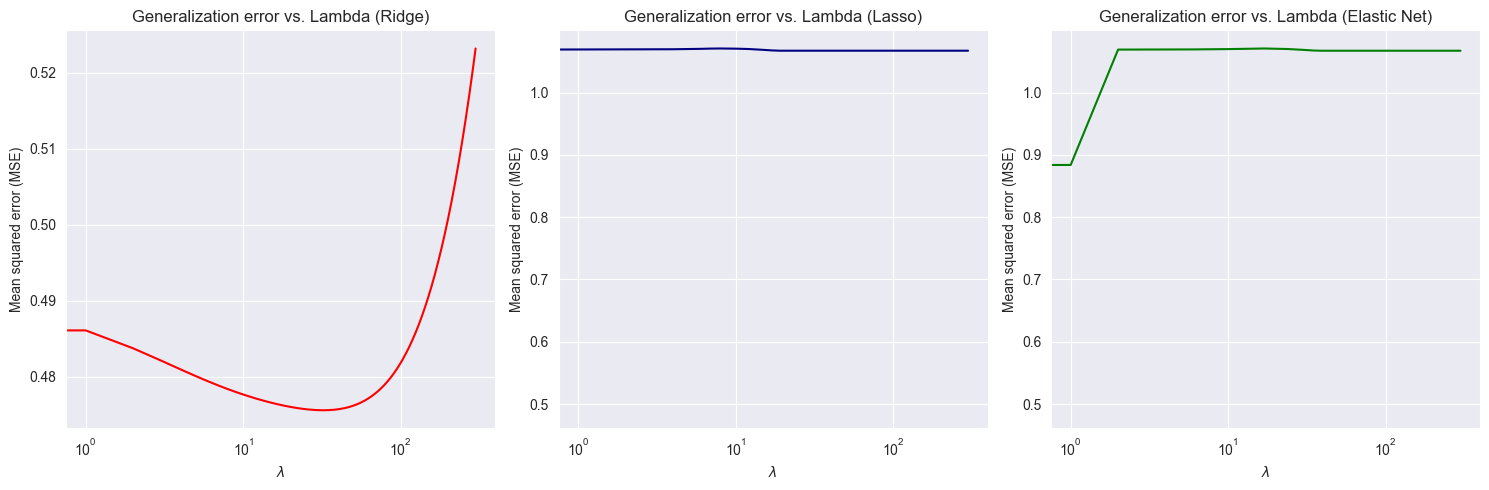

In [19]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Diccionarios para almacenar los resultados de cada modelo
ridge_results = {}
lasso_results = {}
elastic_net_results = {}

# Itera a través de los valores de lambda y realiza la validación cruzada
# Para cada lambda se obtiene un resultado el qual se almacena en los diccionarios declarados arriba.
# Tres tipos de cross validation diferentes.
for lambda_val in lambdas:
    # Ridge Model
    ridge_model = Ridge(alpha=lambda_val)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        ridge_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_val] = ridge_mse

    # Lasso Model
    lasso_model = Lasso(alpha=lambda_val)
    lasso_scores = cross_val_score(
        lasso_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    lasso_mse = -np.mean(lasso_scores)
    lasso_results[lambda_val] = lasso_mse

    # Elastic Net Model
    elastic_net_model = ElasticNet(
        alpha=lambda_val, l1_ratio=0.5
    )  # l1_ratio = 0.5 para balancear L1 y L2
    elastic_net_scores = cross_val_score(
        elastic_net_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    elastic_net_mse = -np.mean(elastic_net_scores)
    elastic_net_results[lambda_val] = elastic_net_mse


print("Ridge results: ", ridge_results)
print("Lasso results: ", lasso_results)
print("ElasticNet results: ", elastic_net_results)

# Crear una figura con una fila y tres columnas
plt.figure(figsize=(8, 5))
plt.subplots(1, 3, figsize=(15, 5))

# Graficar los resultados para Ridge
plt.subplot(1, 3, 1)
plt.plot(
    lambdas, list(ridge_results.values()), linestyle="-", color="red", label="Ridge"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Ridge)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Lasso
plt.subplot(1, 3, 2)
plt.plot(
    lambdas, list(lasso_results.values()), linestyle="-", color="navy", label="Lasso"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Lasso)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Elastic Net
plt.subplot(1, 3, 3)
plt.plot(
    lambdas,
    list(elastic_net_results.values()),
    linestyle="-",
    color="g",
    label="Elastic Net",
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Elastic Net)")
plt.xscale("log")
plt.grid(True)

# Ajustar los subplots para evitar solapamiento
plt.tight_layout()

# Guardar la figura como un archivo PDF
# plt.savefig("combined_regression_results.pdf")

# Mostrar la figura en la pantalla
plt.show()

In [20]:
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = ridge_model.predict(X_test)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculate R2
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.44904024799232045
MSE: 0.4205956479531805
RMSE: 0.6485334593937159
R2: 0.5201411748485991


4. Find the λ that gives the lowest generalization error


Values of coefficients are the weigths for each feature and intercept is the bias term
$$y=(biasterm) + weigths*(features)$$


In [22]:
# Create and train a Ridge regression model
model = Ridge(alpha=best_lambda)  # Use the best_alpha value you've determined
model.fit(X_std, y_std)  # X is your feature matrix, y is your target variable

# Access the coefficients
coefficients = model.coef_  # Coefficients (weights)
intercept = model.intercept_  # Intercept (bias term)

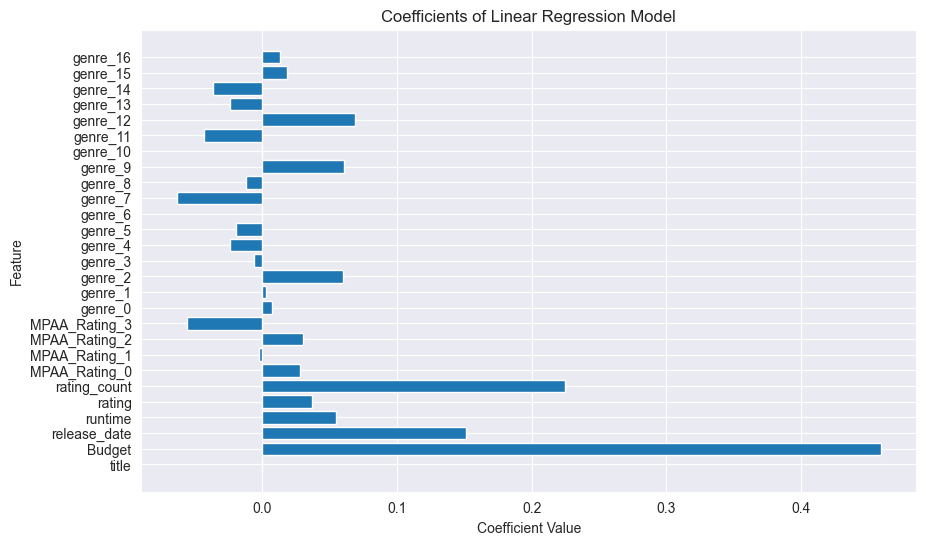

In [23]:
feature_names = X_std.columns
# Creare un grafico a barre per visualizzare i coefficienti
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Coefficients of Linear Regression Model")
plt.show()

In [24]:
print(f"y = {intercept} + coefficients * weigths")

y = 0.06586871355218217 + coefficients * weigths


This is the plot as 14.2 in the book


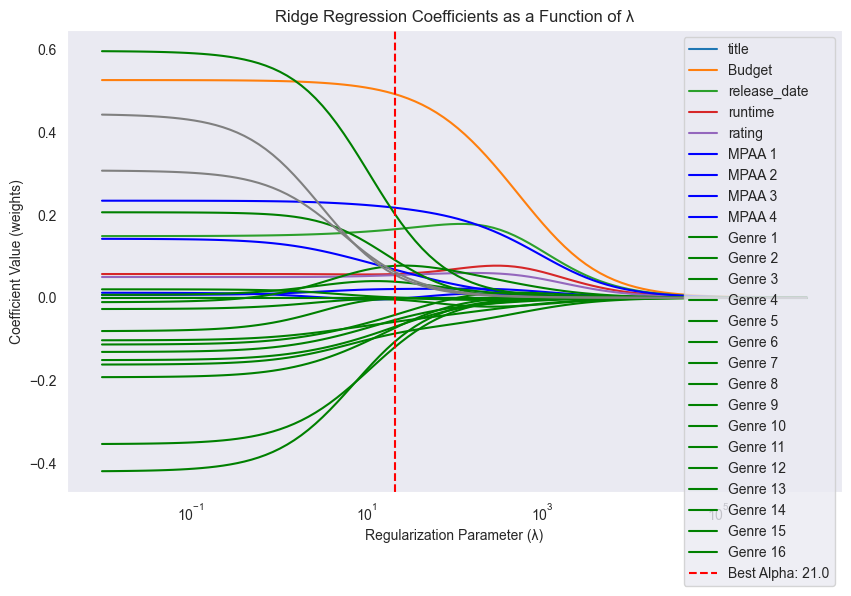

In [25]:
coefficients = []
lambdas1 = np.logspace(-2, 6, 100, base=10)

for alpha in lambdas1:
    # Create and fit a Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)  # Use your transformed data

    # Get the coefficients for this λ
    coef = model.coef_
    coefficients.append(coef)

# Convert coefficients to a NumPy array
coefficients = np.array(coefficients)

# Create a plot to visualize the coefficients
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    if 0 <= i <= 4:
        plt.semilogx(lambdas1, coefficients[:, i], label=f"{X_std.columns[i]}")
    elif 5 <= i <= 8:
        plt.semilogx(
            lambdas1,
            coefficients[:, i],
            color="blue",
            linestyle="-",
            label=f"MPAA {i-4}",
        )
    elif 9 <= i <= 24:
        plt.semilogx(
            lambdas1,
            coefficients[:, i],
            color="green",
            linestyle="-",
            label=f"Genre {i-8}",
        )
    else:
        plt.semilogx(
            lambdas1, coefficients[:, i], color="gray"
        )  # Plot features outside the range in gray

# Add a vertical line for the best_alpha
plt.axvline(x=best_alpha, color="r", linestyle="--", label=f"Best Alpha: {best_alpha}")

plt.title("Ridge Regression Coefficients as a Function of λ")
plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Coefficient Value (weights)")
plt.legend()

plt.grid()
plt.show()

## Regression part b


In this section, we will compare three models: the regularized
linear regression model from the previous section, an artificial neural network (ANN) and a baseline.

We are interested in two questions:

- Is one model better than the other?
- Is either model better than a trivial baseline?.

We will attempt to answer
these questions with two-level cross-validation.


### 1 Implement two-level cross-validation

(see algorithm 6 of the lecture notes). We will use 2-level cross-validation to compare the models with K1 = K2 = 10 folds.

As a baseline model, we will apply a linear regression model with no features, i.e. it computes the mean of y on the training data, and use this value to predict y on the test data.

Make sure you can fit an ANN model to the data.

As complexity-controlling parameter for the ANN, we will use the number of hidden units5 h.
Based on a few test-runs, select a reasonable range of values for h (which should include h = 1), and describe the range of values you will use for h and λ.


The baseline model is a simple linear regression model that computes the mean of the target variable (y) on the training data and uses this mean value to predict y on the test data.


In [26]:
import torch
from toolbox_functions import train_neural_net
from sklearn import model_selection

Model for ANN analysis


In [55]:
# Parameters for Neural Network
n_hidden_units_range = range(1, 6)  # Testing values from 1 to 10
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 1000
N, M = X_std.shape  # Use the standardized X

def model_ANN(n_hidden_units):
    return torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
        torch.nn.ReLU(),  # 1st transfer function,
        torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
        # no final transfer function, i.e. "linear output"
    )


loss_fn = torch.nn.MSELoss()

In [58]:
from sklearn.model_selection import cross_validate

# Variables for statistical evaluation
y_true_kf = []
yhat_kf = []

# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=42)

# Lists to store the results for each fold
fold_numbers = []
baseline_mse_values = []
ridge_best_errors = []
ridge_best_lambdas = []
ridge_test_errors = []
ann_n_hidden_units = []
ann_best_losses = []
ann_test_errors = []

# Loop over each fold
for k, (train_index, test_index) in enumerate(outer_cv.split(X_std)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, outer_folds))

    ## INDEX EXTRACTION
    X_par = X_std.iloc[train_index]
    y_par = y_std.iloc[train_index].to_numpy()
    X_test = X_std.iloc[test_index]
    y_test = y_std.iloc[test_index].to_numpy()
    y_true_kf.append(y_test)

    ## BASELINE NO LAMBDA NO FEATURES
    y_mean = np.mean(y_par)
    y_pred_baseline = np.full(y_test.shape, y_mean)
    mse_baseline = ((y_pred_baseline - y_test) ** 2).mean()
    yhat_baseline = y_pred_baseline.reshape(-1,1)

    # Store the results for the baseline model
    fold_numbers.append(k + 1)
    baseline_mse_values.append(mse_baseline)

    ## RIDGE REGRESSION
    lambdas = np.arange(1, 200, 1, dtype="float")
    errors_ridge = []
    best_error_lambda_i = 1
    best_lambda_i_ridge = None
    best_fitted_regression_model = None

    for lambda_i in lambdas:
        ridge_model = Ridge(alpha=lambda_i)
        cv_results = cross_validate(ridge_model, X_par, y_par, cv=inner_folds, scoring='neg_mean_squared_error', return_estimator=True)
         # Access the scores and fitted models
        scores = cv_results['test_score']
        fitted_models = cv_results['estimator']
        # scores = cross_val_score(ridge_model, X_par, y_par, cv=inner_folds)
        mean_score = scores.mean()
        gen_err_lambda_i_ridge = -mean_score
        errors_ridge.append(gen_err_lambda_i_ridge)

        if gen_err_lambda_i_ridge < best_error_lambda_i:
            best_error_lambda_i = gen_err_lambda_i_ridge
            best_lambda_i_ridge = lambda_i

        # Find the index of the best score
        best_model_index = scores.argmin()

        # Obtain the best fitted model
        best_fitted_regression_model = fitted_models[best_model_index]

    # Store the results for Ridge Regression
    ridge_best_errors.append(best_error_lambda_i)
    ridge_best_lambdas.append(best_lambda_i_ridge)

    yhat_regression = best_fitted_regression_model.predict(X_test).reshape(-1,1)

    ## ANN
    fitted_models = []
    errors_NN = []
    for n_hidden_units in n_hidden_units_range:
        # Inner CV
        errors_NN_inner = []
        nn_model = model_ANN(n_hidden_units)

        for (train_index_inner, test_index_inner) in inner_cv.split(X_par, y_par):
            X_train_inner = torch.Tensor(X_par.iloc[train_index_inner,:].values)
            y_train_inner = torch.Tensor(y_par[train_index_inner])
            X_test_inner = torch.Tensor(X_par.iloc[test_index_inner,:].values)
            y_test_inner = torch.Tensor(y_par[test_index_inner])

            net, final_loss, learning_curve = train_neural_net(
                lambda: nn_model,
                loss_fn,
                X=torch.Tensor(X_train_inner),
                y=torch.Tensor(y_train_inner),
                n_replicates=n_replicates,
                max_iter=max_iter,
                tolerance=1e-6,
            )

            # Determine estimated class labels for the test set
            y_test_est_inner = net(torch.Tensor(X_test_inner))

            # Determine errors
            se = (y_test_est_inner.detach().numpy() - y_test_inner.numpy()) ** 2
            mse_NN_inner = np.mean(se)
            errors_NN_inner.append(mse_NN_inner)

        mse_NN = np.array(errors_NN_inner).mean()
        errors_NN.append(mse_NN)
        fitted_models.append(nn_model)

    # Find the best result for ANN
    best_n_hidden_units = n_hidden_units_range[np.argmin(errors_NN)]
    best_loss_ann = np.min(errors_NN)

    # Find the index of the best score
    best_model_index = np.argmin(errors_NN)

    # Obtain the best fitted model
    best_fitted_model = fitted_models[best_model_index]
    yhat_ann = best_fitted_model(torch.Tensor(X_test.values)).detach().numpy()

    # Store the results for ANN
    ann_n_hidden_units.append(best_n_hidden_units)
    ann_best_losses.append(best_loss_ann)

    # Statistical evaluation data preparation
    yhat_kf.append( np.concatenate([yhat_baseline, yhat_regression, yhat_ann], axis=1) )

y_true_kf = np.concatenate(y_true_kf)
yhat_kf = np.concatenate(yhat_kf)

# Store the results in a DataFrame
df = pd.DataFrame(
    {
        "Fold": fold_numbers,
        "Baseline MSE": baseline_mse_values,
        "Ridge Best Error": ridge_best_errors,
        "Ridge Best Lambda": ridge_best_lambdas,
        "ANN Best Hidden Units": ann_n_hidden_units,
        "ANN Best Loss": ann_best_losses,
    }
)

# Print the table
print(df)


Crossvalidation fold: 1/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.9757493	6.541885e-05
		Final loss:
		1640	0.96450645	9.887683e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		64	1.0330979	9.231201e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		226	0.99597484	8.976822e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	2.7820644	0.0073315147
		2000	1.1008518	6.7138253e-06
		Final loss:
		2000	1.1008518	6.7138253e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	7.913412	0.009629947
		2000	1.4948635	2.360424e-05
		Final loss:
		2000	1.4948635	2.360424e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	1.5498023	3.0920495e-05
		2000	1.4896047	4.857431e-05
		Final loss:
		2000	1.4896047	4.857431e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	1.029671	0.00013069194
		Final loss:
		1896	0.99966097	9.539968e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		695	1.0476607	9.1028846e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final lo

In [64]:
import numpy as np, scipy.stats as st
# Statistical evaluation calculation
y_true = y_true_kf
yhat = yhat_kf

# Perform statistical comparison of the models
# Compute z with squared error.
zBaseline = np.abs(y_true - yhat[:,0] ) ** 2
zRegression = np.abs(y_true - yhat[:,1] ) ** 2
zAnn = np.abs(y_true - yhat[:,2] ) ** 2

# Compute confidence intervals of models
alpha = 0.05
CIBaseline = st.t.interval(1-alpha, df=len(zBaseline)-1, loc=np.mean(zBaseline), scale=st.sem(zBaseline)) # Confidence interval
CIRegression = st.t.interval(1-alpha, df=len(zRegression)-1, loc=np.mean(zRegression), scale=st.sem(zRegression))
CIAnn = st.t.interval(1-alpha, df=len(zAnn)-1, loc=np.mean(zAnn), scale=st.sem(zAnn))

# Compute confidence intervals of z = zA-zB and p-value of Null hypothesis
# Baseline - Regression
zBaseReg = zBaseline - zRegression
CI_BaseReg = st.t.interval(1-alpha, len(zBaseReg)-1, loc=np.mean(zBaseReg), scale=st.sem(zBaseReg))  # Confidence interval
p_BaseReg = 2*st.t.cdf( -np.abs( np.mean(zBaseReg) )/st.sem(zBaseReg), df=len(zBaseReg)-1)  # p-value

print("Baseline - Regression")
print(f"CIA: {CIBaseline}, CIB: {CIRegression}, CI: {CI_BaseReg}")
print(f"p-value for CI: {p_BaseReg}")

# Baseline - ANN
zBaseANN = zBaseline - zAnn
CI_BaseANN = st.t.interval(1-alpha, len(zBaseANN)-1, loc=np.mean(zBaseANN), scale=st.sem(zBaseANN))  # Confidence interval
p_BaseANN = 2*st.t.cdf( -np.abs( np.mean(zBaseANN) )/st.sem(zBaseANN), df=len(zBaseANN)-1)  # p-value

print("Baseline - ANN")
print(f"CIA: {CIBaseline}, CIB: {CIAnn}, CI: {CI_BaseANN}")
print(f"p-value for CI: {p_BaseANN}")

# Regression - ANN
zRegANN = zRegression - zAnn
CI_RegANN = st.t.interval(1-alpha, len(zRegANN)-1, loc=np.mean(zRegANN), scale=st.sem(zRegANN))  # Confidence interval
p_RegANN = 2*st.t.cdf( -np.abs( np.mean(zRegANN) )/st.sem(zRegANN), df=len(zRegANN)-1)  # p-value

print("Regression - ANN")
print(f"CIA: {CIRegression}, CIB: {CIAnn}, CI: {CI_RegANN}")
print(f"p-value for CI: {p_RegANN}")

Baseline - Regression
CIA: (0.7401552748567739, 1.2767588581690683), CIB: (0.33534145129193893, 0.632569585846317), CI: (0.3882740636570601, 0.6607290322305261)
p-value for CI: 1.4548700612471862e-13
Baseline - ANN
CIA: (0.7401552748567739, 1.2767588581690683), CIB: (0.7439259595669052, 1.2848375089271091), CI: (-0.04030384669171907, 0.028454511223546912)
p-value for CI: 0.7351540091788826
Regression - ANN
CIA: (0.33534145129193893, 0.632569585846317), CIB: (0.7439259595669052, 1.2848375089271091), CI: (-0.6772689091703081, -0.3835835221854502)
p-value for CI: 3.592888359477681e-12
